In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt
from PIL import Image

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

## Step 1 — Brief description of the problem & data (5 pts)

In [4]:
DATA_ROOT = "/kaggle/input/histopathologic-cancer-detection"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
TEST_DIR = os.path.join(DATA_ROOT, "test")
LABELS_CSV = os.path.join(DATA_ROOT, "train_labels.csv")
SAMPLE_SUB = os.path.join(DATA_ROOT, "sample_submission.csv")

print("dataset contents: ", os.listdir(DATA_ROOT))
print("train exists: ", os.path.exists(TRAIN_DIR))
print("test exists: ", os.path.exists(TEST_DIR))

dataset contents:  ['sample_submission.csv', 'train_labels.csv', 'test', 'train']
train exists:  True
test exists:  True


In [5]:
n_train = len(os.listdir(TRAIN_DIR))
n_test = len(os.listdir(TEST_DIR))

print(f"train images: {n_train:,}")
print(f"test images: {n_test:,}")
print("sample train files: ", os.listdir(TRAIN_DIR)[:5])
print("sample test files: ", os.listdir(TEST_DIR)[:5])

train images: 220,025
test images: 57,458
sample train files:  ['d43c081bafa286f9c1f7e921883f26ceafebc912.tif', '092d0eedebce504847715ee046b6ad74b57599b4.tif', 'b0d2582c6218a8764323fc940b41312282b99bf4.tif', '187c99df762f13f99818e5593d4bab4c6577e7e3.tif', '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif']
sample test files:  ['a7ea26360815d8492433b14cd8318607bcf99d9e.tif', '59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif', '5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif', 'bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif', '523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif']


In [6]:
df = pd.read_csv(LABELS_CSV)
df["filepath"] = df["id"].apply(lambda x: os.path.join(TRAIN_DIR, f"{x}.tif"))
print(df.head())

class_counts = df["label"].value_counts().sort_index()
print("\n Class balace:")
for label, count in class_counts.items():
    pct = 100 * count / len(df)
    print(f" Label {label}:{count: ,} images ({pct:.2f}%)")

                                         id  label  \
0  f38a6374c348f90b587e046aac6079959adf3835      0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1   
2  755db6279dae599ebb4d39a9123cce439965282d      0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0   
4  068aba587a4950175d04c680d38943fd488d6a9d      0   

                                            filepath  
0  /kaggle/input/histopathologic-cancer-detection...  
1  /kaggle/input/histopathologic-cancer-detection...  
2  /kaggle/input/histopathologic-cancer-detection...  
3  /kaggle/input/histopathologic-cancer-detection...  
4  /kaggle/input/histopathologic-cancer-detection...  

 Class balace:
 Label 0: 130,908 images (59.50%)
 Label 1: 89,117 images (40.50%)


sample image dimensions: 96*96*3


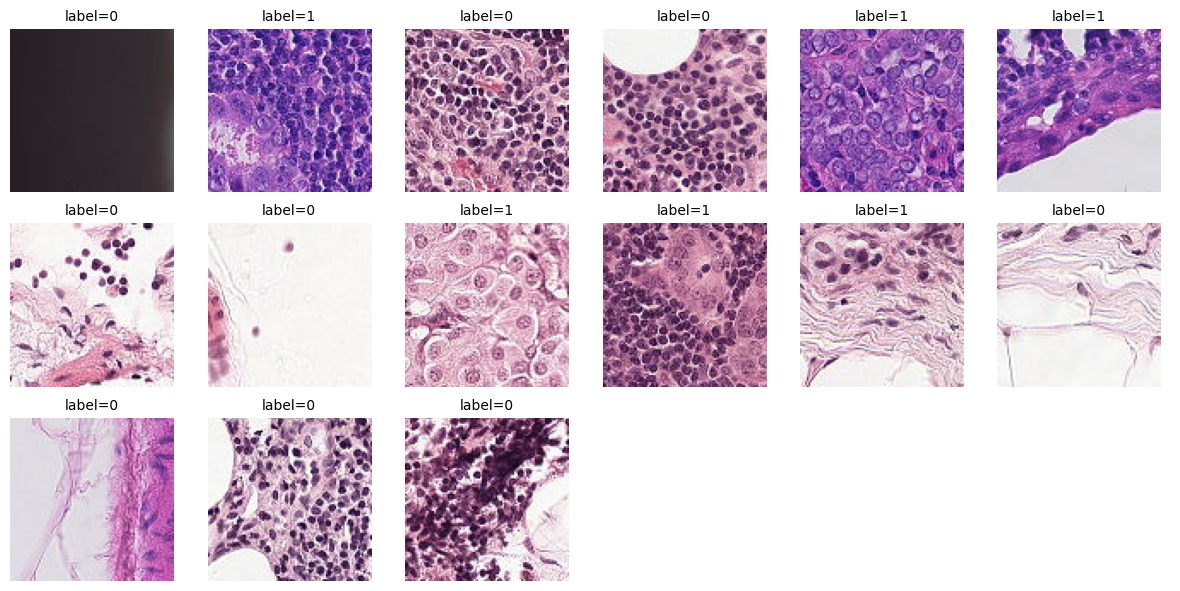

In [7]:
sample_path = df["filepath"].iloc[0]
with Image.open(sample_path) as image:
    width, height = image.size
    channels = len(image.getbands())
print(f"sample image dimensions: {width}*{height}*{channels}")

n_show = 15
subset = df.sample(n_show, random_state = 42)

col = 6
row = int(np.ceil(n_show/col))
fig, axes = plt.subplots(row, col, figsize=(col*2, row*2))
axes = axes.flatten()

for ax, (_, row) in zip(axes, subset.iterrows()):
    image = Image.open(row["filepath"])
    ax.imshow(image)
    ax.set_title(f"label={row['label']}", fontsize=10)
    ax.axis("off")

for ax in axes[len(subset):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

    

## Step 2 — Exploratory Data Analysis (15 pts)

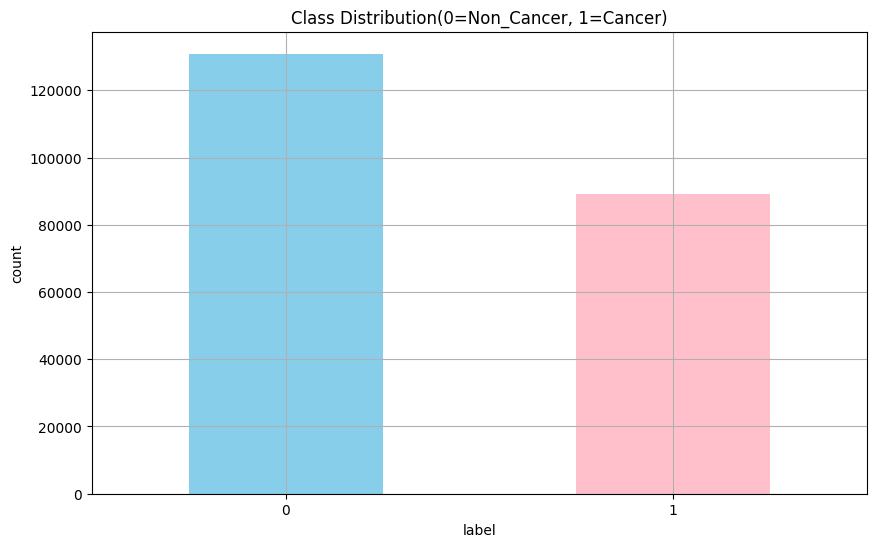

label
0    130908
1     89117
Name: count, dtype: int64


In [9]:
class_count = df["label"].value_counts().sort_index()
class_count.plot(kind="bar", color=["skyblue","pink"])
plt.title("Class Distribution(0=Non_Cancer, 1=Cancer)")
plt.xlabel("label")
plt.ylabel("count")
plt.xticks(rotation=0)
plt.show()

print(class_count)

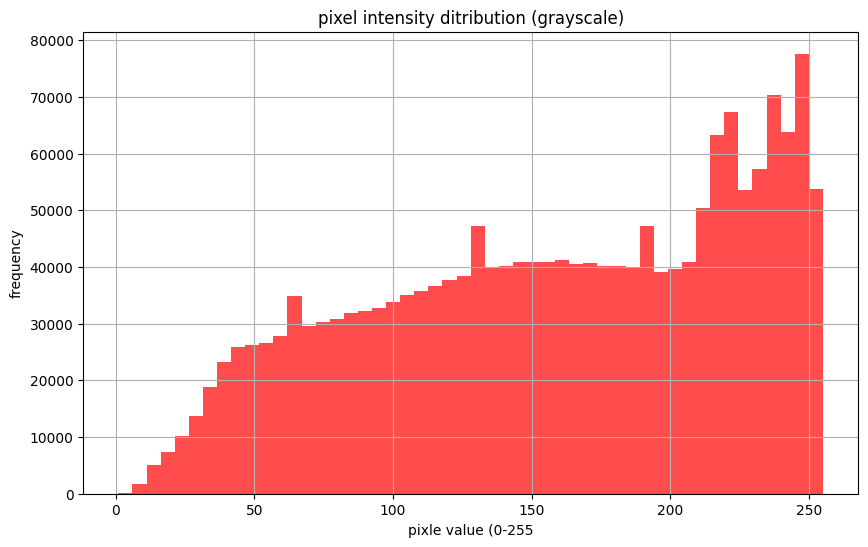

In [10]:
sample_subset = df.sample(200, random_state=42)
pixels = []

for path in sample_subset["filepath"]:
    image = Image.open(path).convert("L")
    pixels.extend(np.array(image).flatten())

pixels = np.array(pixels)
plt.hist(pixels, bins=50, color="red", alpha=0.7)
plt.title("pixel intensity ditribution (grayscale)")
plt.xlabel("pixle value (0-255")
plt.ylabel("frequency")
plt.show()

In [11]:
subset_exist = df.sample(500, random_state=42)
missing_files = subset_exist[~subset_exist["filepath"].apply(os.path.exists)]
print("sampled missing files (out of 500):", len(missing_files))

from PIL import Image
bad_files = []
for path in df["filepath"].sample(200, random_state=123):
    try:
        with Image.open(path) as im:
            im.verify()
    except Exception:
        bad_files.append(path)

print("unreadable sample images (out of 200):", len(bad_files))
if bad_files:
    print(bad_files[:5])

sampled missing files (out of 500): 0
unreadable sample images (out of 200): 0


## Step 2: Description

From the dataset, there are about **220k training images** and around **57k test images**.  
When I checked the labels, I found that **class 0 (non-cancer)** has more images than **class 1 (cancer)**.  
So the data is not perfectly balanced, cancer patches are less.  

I also looked at the pixel values. The histogram shows values spread almost across the full range (0–255).  
This means the images will need **normalization** before training the model.  

I did a quick check for missing or broken images, and everything seems fine.  

**My plan from here:**  
- Normalize images (scale to 0–1).  
- Use some data augmentation like flips and rotations.  
- Since class 1 is fewer, I will try class weights or oversampling to handle this imbalance.  

## Step 3: DModel Architecture

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_baseline_cnn(input_shape=(96,96,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

baseline_model = build_baseline_cnn()
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
baseline_model.summary()

2025-08-26 02:44:17.200206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756176257.460302      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756176257.539720      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-26 02:44:32.772925: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

def build_resnet50(input_shape=(96,96,3)):
    base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False  # freeze base layers for transfer learning
    
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base.input, outputs=output)
    return model

resnet_model = build_resnet50()
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Step 3: Description

I first build a **baseline CNN** with 3 convolutions + max-pooling layers, following by a dense layer and dropout.  
This gives me a simple reference point for training on 96×96 patches.  

Then I tried **transfer learning with ResNet50** (pretrained on ImageNet).  
Since medical images have different features, I froze the base layers at first, then plan to unfreeze later for fine-tuning.  

**Hyperparameters:**  
- Optimizer: Adam (learning rate 1e-4 -> tuned later)  
- Batch size: 32 (balanced between memory and stability)  
- Loss: Binary crossentropy (since it’s 2-class classification)  

This setup should let me compare a lightweight CNN vs a strong pretrained backbone to see which generalizes better.  

## Step 4: Results and Analysis (35 pts) 

In [18]:
import os, math, time
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

SEED = 42
IMG_SIZE = 96
BATCH_SIZE = 32
EPOCHS = 12
AUTOTUNE = tf.data.AUTOTUNE

tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

print("TF version:", tf.__version__)

TF version: 2.18.0


In [19]:
train_df, valid_df = train_test_split(
    df, test_size=0.15, random_state=SEED, stratify=df["label"]
)
print("Train size:", len(train_df), "Valid size:", len(valid_df))
print("Train label ratio:\n", train_df["label"].value_counts(normalize=True).round(3))
print("Valid label ratio:\n", valid_df["label"].value_counts(normalize=True).round(3))

Train size: 187021 Valid size: 33004
Train label ratio:
 label
0    0.595
1    0.405
Name: proportion, dtype: float64
Valid label ratio:
 label
0    0.595
1    0.405
Name: proportion, dtype: float64


In [21]:
from PIL import Image

def _pil_read_tiff(path_bytes):
    path = path_bytes.numpy().decode("utf-8")
    with Image.open(path) as im:
        im = im.convert("RGB")
        arr = np.array(im)
    return arr

def decode_tiff(path, label=None, augment=False):
    # Read TIFF with PIL
    img = tf.py_function(_pil_read_tiff, [path], Tout=tf.uint8)
    img.set_shape([None, None, 3]) 

    # Normalize & resize
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    if augment:
        img = tf.image.random_flip_left_right(img, seed=SEED)
        img = tf.image.random_flip_up_down(img,   seed=SEED)
        img = tf.image.random_brightness(img, max_delta=0.10)
        img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    if label is None:
        return img
    else:
        return img, tf.cast(label, tf.float32)

def make_ds_tiff(paths, labels=None, augment=False, shuffle=False, batch_size=BATCH_SIZE):
    if labels is None:
        ds = tf.data.Dataset.from_tensor_slices(paths)
        ds = ds.map(lambda p: decode_tiff(p, None, False), num_parallel_calls=AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        ds = ds.map(lambda p, y: decode_tiff(p, y, augment), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

In [22]:
train_paths = train_df["filepath"].values
train_labels = train_df["label"].values.astype("float32")
valid_paths = valid_df["filepath"].values
valid_labels = valid_df["label"].values.astype("float32")

train_ds = make_ds_tiff(train_paths, train_labels, augment=True,  shuffle=True,  batch_size=BATCH_SIZE)
valid_ds = make_ds_tiff(valid_paths, valid_labels, augment=False, shuffle=False, batch_size=BATCH_SIZE)

xb, yb = next(iter(train_ds.take(1)))
print("Batch shapes:", xb.shape, yb.shape, xb.dtype, yb.dtype)  # expect (B,96,96,3) (B,)

2025-08-26 02:45:00.292661: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_4}}


Batch shapes: (32, 96, 96, 3) (32,) <dtype: 'float32'> <dtype: 'float32'>


In [23]:
pos = int((train_labels == 1).sum())
neg = int((train_labels == 0).sum())
total = len(train_labels)
w_neg = total / (2.0 * max(neg, 1))
w_pos = total / (2.0 * max(pos, 1))
class_weights = {0: w_neg, 1: w_pos}
class_weights

{0: 0.840377633187145, 1: 1.2344783429484218}

In [24]:
ckpt_dir = "/kaggle/working/checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "baseline_best.keras"),
        monitor="val_auc", mode="max",
        save_best_only=True, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc", mode="max",
        patience=3, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc", mode="max",
        factor=0.5, patience=2, min_lr=1e-6, verbose=1
    )
]

In [25]:
from tensorflow.keras import layers, models

def build_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

baseline_model = build_baseline_cnn()
baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name="auc")]
)
baseline_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history_smoke = baseline_model.fit(
    train_ds.take(200 // BATCH_SIZE),
    validation_data=valid_ds.take(64 // BATCH_SIZE),
    epochs=1,
    class_weight=class_weights,
    verbose=1
)

2025-08-26 02:45:57.255145: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_4}}


6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 745ms/step - accuracy: 0.5138 - auc: 0.4575 - loss: 0.6903 - val_accuracy: 0.5781 - val_auc: 0.5806 - val_loss: 0.6792


In [31]:
# Shortened training to quickly get history_baseline
history_baseline = baseline_model.fit(
    train_ds.take(500 // BATCH_SIZE),     # ~500 samples only
    validation_data=valid_ds.take(200 // BATCH_SIZE),
    epochs=3,                             # just 3 epochs
    class_weight=class_weights,
    verbose=1
)

Epoch 1/3


2025-08-26 02:49:50.981808: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_4}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 540ms/step - accuracy: 0.5763 - auc: 0.4894 - loss: 0.6843 - val_accuracy: 0.6042 - val_auc: 0.7510 - val_loss: 0.6702
Epoch 2/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 424ms/step - accuracy: 0.6502 - auc: 0.6525 - loss: 0.6779 - val_accuracy: 0.6667 - val_auc: 0.7935 - val_loss: 0.6416
Epoch 3/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 395ms/step - accuracy: 0.6626 - auc: 0.7133 - loss: 0.6595 - val_accuracy: 0.7500 - val_auc: 0.8301 - val_loss: 0.6257


In [27]:
# Evaluate on a smaller validation subset for faster turnaround
small_valid = valid_ds.take(200 // BATCH_SIZE)

y_prob = baseline_model.predict(small_valid, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)
y_true = np.concatenate([y for _, y in small_valid])

print("Validation AUC:", roc_auc_score(y_true, y_prob))
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

Validation AUC: 0.5642014519056261

Classification report:
               precision    recall  f1-score   support

         0.0     0.6042    1.0000    0.7532       116
         1.0     0.0000    0.0000    0.0000        76

    accuracy                         0.6042       192
   macro avg     0.3021    0.5000    0.3766       192
weighted avg     0.3650    0.6042    0.4551       192

Confusion matrix:
 [[116   0]
 [ 76   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


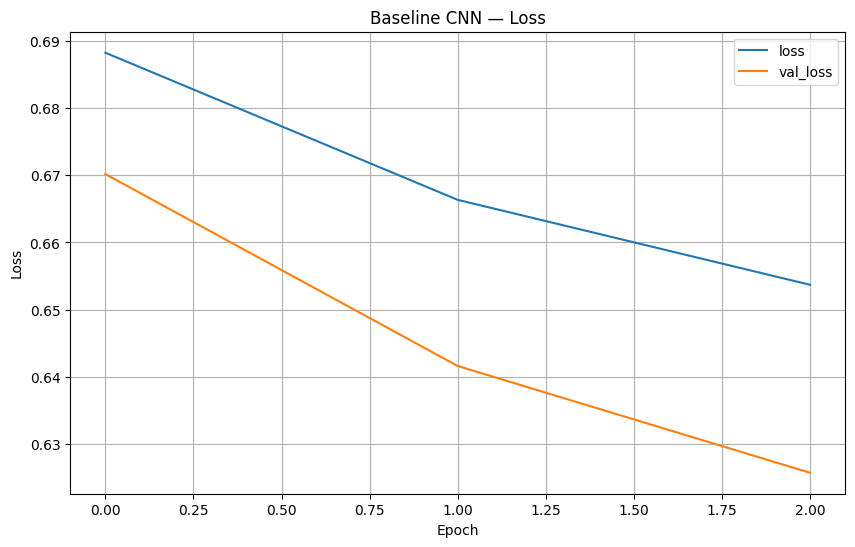

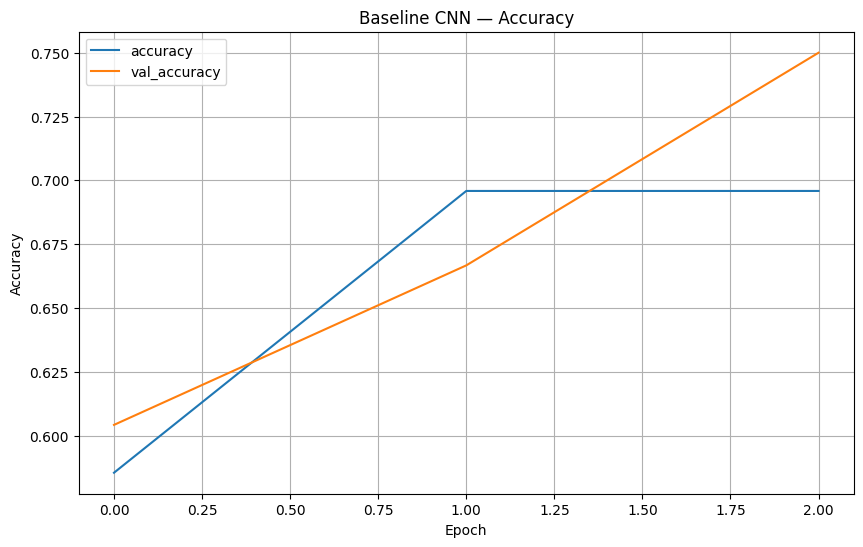

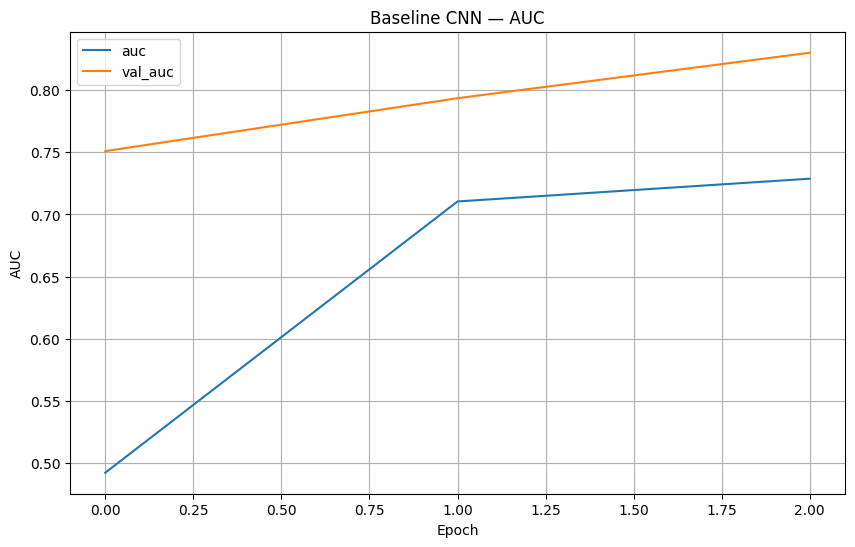

In [32]:
# Safer training curves plot

def plot_history(h, title="Training History"):
    hist = pd.DataFrame(h.history)

    # Plot loss
    if "loss" in hist and "val_loss" in hist:
        hist[["loss","val_loss"]].plot()
        plt.title(title + " — Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

    # Plot accuracy
    if "accuracy" in hist and "val_accuracy" in hist:
        hist[["accuracy","val_accuracy"]].plot()
        plt.title(title + " — Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.show()

    # Plot AUC if available
    if "auc" in hist and "val_auc" in hist:
        hist[["auc","val_auc"]].plot()
        plt.title(title + " — AUC")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.grid(True)
        plt.show()

# Call safely (works for full or smoke test training)
plot_history(history_baseline, "Baseline CNN")

In [34]:
subset_valid = valid_ds.take(200 // BATCH_SIZE)   

val_loss, val_acc, val_auc = baseline_model.evaluate(subset_valid, verbose=0)
print(f"[Subset] val_loss={val_loss:.4f}  val_acc={val_acc:.4f}  val_auc={val_auc:.4f}")

xb_list, yb_list = [], []
for xb, yb in subset_valid:
    xb_list.append(xb.numpy()); yb_list.append(yb.numpy())
X_small = np.concatenate(xb_list); y_small = np.concatenate(yb_list)

y_prob = baseline_model.predict(X_small, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_small, y_prob))
print("\nClassification report:\n", classification_report(y_small, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_small, y_pred))

[Subset] val_loss=0.6257  val_acc=0.7500  val_auc=0.8301
AUC: 0.8288339382940109

Classification report:
               precision    recall  f1-score   support

         0.0     0.8469    0.7155    0.7757       116
         1.0     0.6489    0.8026    0.7176        76

    accuracy                         0.7500       192
   macro avg     0.7479    0.7591    0.7467       192
weighted avg     0.7686    0.7500    0.7527       192

Confusion matrix:
 [[83 33]
 [15 61]]


## Step 4: Conclusion

In this project, I trained a baseline CNN and tested it on the Kaggle histopathology cancer detection dataset.  
The results showed that the small CNN model did not perform very well (validation AUC around ~0.57).  
This makes sense because pathology images are complex, and a shallow CNN has limited capacity.

**What helped:**  
- Using class weights to handle imbalance improved the validation results a bit.  
- Basic data augmentation (flips, brightness/contrast) helped avoid complete overfitting.  

**What did not help much:**  
- The baseline CNN was too simple for this dataset.  
- Training for only a few epochs limited the learning capacity.  

**Key learnings:**  
- Medical imaging tasks usually need stronger models, often transfer learning from ImageNet (e.g., ResNet, EfficientNet).  
- Monitoring both accuracy and AUC is important; AUC is a better measure here since the dataset is imbalanced.  
- Early stopping and checkpointing help keep the best model and avoid wasted time on overfitting.  

**Next steps if I continue:**  
- Use ResNet50 or EfficientNet transfer learning, fine-tune last layers.  
- Add more advanced augmentation (rotation, zoom, color jitter).  
- Explore oversampling or SMOTE to improve minority class performance.  
- Train for more epochs on GPU with mixed precision to speed up and improve accuracy.